In [42]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [104]:
# CARREGAR OS DADOS

def carregar_ecgs(normal, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, normal) if len(ecg_normal_id) >= normal else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []
    processed_ids = []  # Lista para armazenar os IDs dos ECGs que foram processados corretamente

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    processed_ids.append(exam_id)  # Adicionar o ID correspondente
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X, processed_ids

Número de linhas ecg_normal_linhas: 119461
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116139
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 1000
Número de ecgs que eram pra ser processados: 1000
Número total de traçados processados: 1000


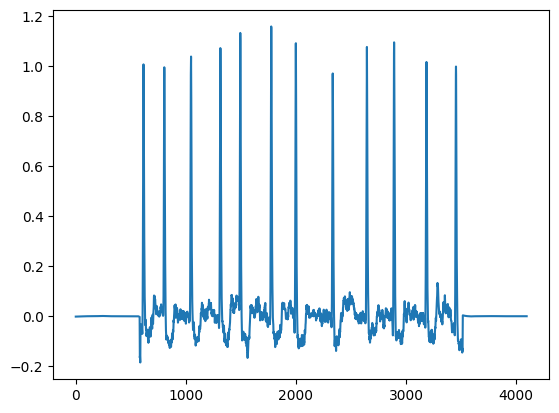

In [126]:
X, ID = carregar_ecgs(normal=0,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=1000,filtrado=True)

plt.plot(X[0][0])

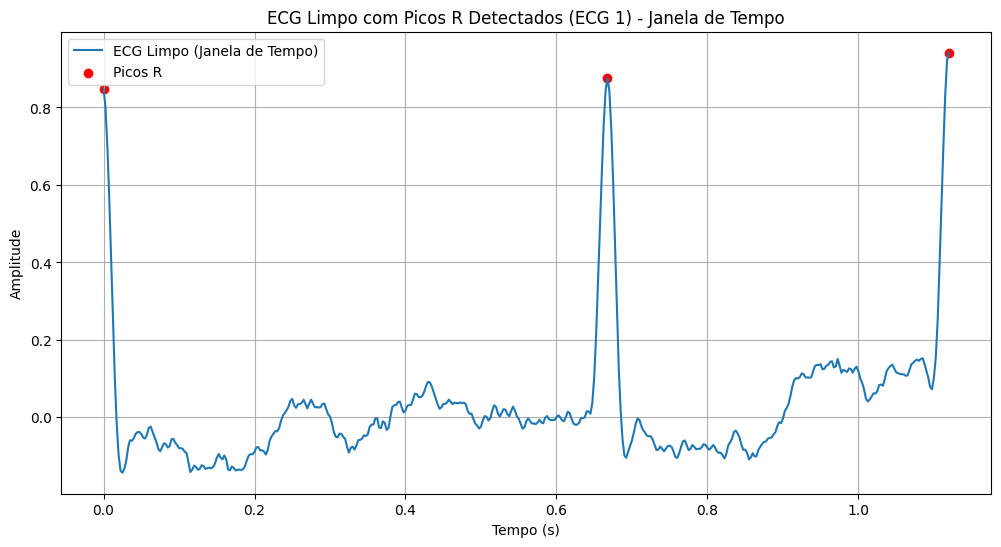

ECG 871: Não foram detectados picos R suficientes para processamento.
ECG 871: Não possui dados suficientes para criar a janela de 700 pontos a partir do ponto 1500.


In [127]:
def processar_ecgs_multileads(ecgs):
    """
    Processa um vetor de ECGs com múltiplas derivações. Para cada ECG, limpa o sinal na primeira derivação,
    detecta os picos R e faz o corte sincronizado em todas as derivações.

    Parâmetros:
    ecgs: array 3D (n_ecgs x n_leads x n_samples) - Matriz contendo vários ECGs de múltiplas derivações

    Retorno:
    novo_ecgs: lista de arrays - Lista de ECGs processados
    r_peaks_list: lista de arrays - Lista contendo os índices dos R peaks relativos para cada ECG
    """
    n_ecgs, n_leads, n_samples = ecgs.shape
    novo_ecgs = []        # Lista para armazenar os novos ECGs processados
    r_peaks_list = []     # Lista para armazenar os R peaks de cada ECG
    picos_reais = []
    for i in range(n_ecgs):
        # Para cada ECG, obter as derivações
        ecg = ecgs[i]

        # Limpar o sinal da primeira derivação
        first_lead = ecg[1]
        sampling_rate = 400
        

        # Detectar picos R no sinal limpo
        peaks = nk.ecg_findpeaks(first_lead, sampling_rate=sampling_rate)

        # Extrair os índices dos picos R da primeira derivação
        r_peaks = peaks['ECG_R_Peaks']

        # Verificar se há picos suficientes
        # Verificar se há picos suficientes
        if len(r_peaks) < 3:
            print(f"ECG {i + 1}: Não foram detectados picos R suficientes para processamento.")
            
            # Verificar se há pontos suficientes para criar a janela de 700 pontos
            if len(ecg) >= 2200:  # 1500 + 700 = 2200
                # Adiciona uma janela de 700 pontos começando no ponto 1500
                novo_ecg = ecg[1500:1500+700]
            else:
                print(f"ECG {i + 1}: Não possui dados suficientes para criar a janela de 700 pontos a partir do ponto 1500.")
                novo_ecg = ecg  # Adiciona o ECG original como fallback
            
            novo_ecgs.append(novo_ecg)  # Adiciona o ECG modificado ou original
            r_peaks_list.append([])  # Adiciona uma lista vazia para R peaks
            continue

        # Calcular as distâncias entre os picos consecutivos
        distancias = np.diff(r_peaks)

        # Calcular a mediana das distâncias
        mediana = np.median(distancias)

        # Encontrar o índice do pico cuja distância está mais próxima da mediana
        indice_prox_mediana = np.argmin(np.abs(distancias - mediana))

        # Selecionar os três picos consecutivos
        if indice_prox_mediana + 3 > len(r_peaks):
            # Se não houver picos suficientes, seleciona os últimos três
            novo_ecg_peaks = r_peaks[-3:]
        else:
            novo_ecg_peaks = r_peaks[indice_prox_mediana:indice_prox_mediana + 3]

        # Garantir que temos pelo menos dois pontos para cortar
        if len(novo_ecg_peaks) < 2:
            print(f"ECG {i + 1}: Não foi possível selecionar picos R suficientes para corte.")
            novo_ecgs.append(ecg)  # Adiciona o ECG original sem cortes
            r_peaks_list.append([])  # Adiciona uma lista vazia para R peaks
            continue

        # Definir início e fim da janela
        start = novo_ecg_peaks[0]
        # Ajuste do fim para incluir o último pico sem exceder o número de amostras
        end = novo_ecg_peaks[-1] + 1 if (novo_ecg_peaks[-1] + 1) <= n_samples else novo_ecg_peaks[-1]

        # Criar um novo vetor de ECG para todas as derivações a partir desses picos
        novo_ecg_segmentado = ecg[:, start:end]

        # Substituir ou remover valores NaN
        novo_ecg_segmentado = np.nan_to_num(novo_ecg_segmentado, nan=0.0)

        # Ajustar os R peaks para a janela segmentada (índices relativos)
        r_peaks_window = novo_ecg_peaks - start
        # Garantir que os índices estão dentro dos limites
        r_peaks_window = r_peaks_window[r_peaks_window < (end - start)]

        # Adicionar o novo ECG processado à lista (com diferentes tamanhos)
        novo_ecgs.append(novo_ecg_segmentado)

        # Adicionar os R peaks relativos à lista
        r_peaks_list.append(r_peaks_window)
        
        picos_reais.append(novo_ecg_peaks)
        # Plotar o primeiro ECG como exemplo
        if i == 0:  # Plota apenas o primeiro ECG processado
            time_window = np.arange(end - start) / sampling_rate  # Tempo em segundos
            plt.figure(figsize=(12, 6))
            plt.plot(time_window, first_lead[start:end], label="ECG Limpo (Janela de Tempo)")
            # Ajustar os índices dos picos R para a janela
            plt.scatter(time_window[r_peaks_window], first_lead[novo_ecg_peaks], color='red', label="Picos R")
            plt.title(f"ECG Limpo com Picos R Detectados (ECG {i + 1}) - Janela de Tempo")
            plt.xlabel("Tempo (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.grid()
            plt.show()

    return novo_ecgs, r_peaks_list, picos_reais

# Processar os ECGs
novo_ecg, r_peaks_list, picos = processar_ecgs_multileads(X)

In [128]:
import cupy as cp
import torch
import neurokit2 as nk
from tqdm import tqdm


# Função para calcular features de cada nó
def calcular_features_por_no(vetor):
    features_por_no = []
    n = len(vetor)

    for i in range(n):
        amplitude = vetor[i]
        derivada = vetor[i] - vetor[i - 1] if i > 0 else 0
        
        features_por_no.append({
            "amplitude": float(amplitude),
            "derivada": float(derivada)
        })
    
    return features_por_no

# Função para criar o grafo de visibilidade com features
def criar_grafo_visibilidade_pt(vetor,id_ecg):
    if not isinstance(vetor, cp.ndarray):
        vetor = cp.array(vetor)

    n = len(vetor)
    src_list = []
    dst_list = []

    for i in range(n):
        valor_i = vetor[i]
        indices = cp.arange(i + 1, n)
        if len(indices) == 0:
            continue

        slopes = (vetor[indices] - valor_i) / (indices - i)
        slopes_cpu = cp.asnumpy(slopes)

        max_slope = -float('inf')
        for offset, s in enumerate(slopes_cpu):
            if s > max_slope:
                max_slope = s
                j = i + 1 + offset
                src_list.append(i)
                dst_list.append(j)

    src_t = torch.tensor(src_list, dtype=torch.long)
    dst_t = torch.tensor(dst_list, dtype=torch.long)

    features_por_no = calcular_features_por_no(vetor)

    return {
        'src': src_t,
        'dst': dst_t,
        'features': features_por_no,
        'id': id_ecg   
    }

# Função principal para processar apenas um batimento por ECG
def processar_um_batimento_por_ecg(vetor, ids, output_path='grafos_visibilidade.pt'):
    todos_grafos = []
    vetores_batimentos = []
    n_ecgs = len(vetor)

    for idx in tqdm(range(n_ecgs), desc="Processando ECGs"):
        id_ecg = ids[idx]  # Pegar o ID correspondente ao ECG
        grafo = criar_grafo_visibilidade_pt(vetor[idx][1], id_ecg)
        todos_grafos.append(grafo)
        vetores_batimentos.append(vetor[idx][1])

    # Salvar os grafos com os IDs associados
    torch.save({'grafos': todos_grafos, 'vetores': vetores_batimentos}, output_path)
    print(f"Grafos de visibilidade de um batimento por ECG foram salvos em {output_path}.")

# Exemplo de uso
if __name__ == "__main__":
    processar_um_batimento_por_ecg(novo_ecg, ID, output_path='grafos/af.pt')


Processando ECGs: 100%|██████████| 1000/1000 [01:42<00:00,  9.77it/s]


Grafos de visibilidade de um batimento por ECG foram salvos em grafos/af.pt.


In [113]:
import torch

# Carrega o arquivo .pt
data = torch.load('grafos/umdavb.pt')

# Seleciona o primeiro grafo
primeiro_grafo = data['grafos'][223]

# Calcula o número de nós
n_nos = torch.unique(torch.cat((primeiro_grafo['src'], primeiro_grafo['dst']))).shape[0]

print(f"Primeiro grafo:")
print(f"  Número de nós: {n_nos}")
print(f"  Número de arestas: {primeiro_grafo['src'].shape[0]}")
print(f"  ID: {primeiro_grafo['id']}")


/tmp/ipykernel_1152784/1525532806.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('grafos/umdavb.pt')


Primeiro grafo:
  Número de nós: 4096
  Número de arestas: 4095
  ID: 3800354


/tmp/ipykernel_1152784/2202748464.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dados_salvos = torch.load(pt_path)


Grafo criado com 4096 nós e 4095 arestas.


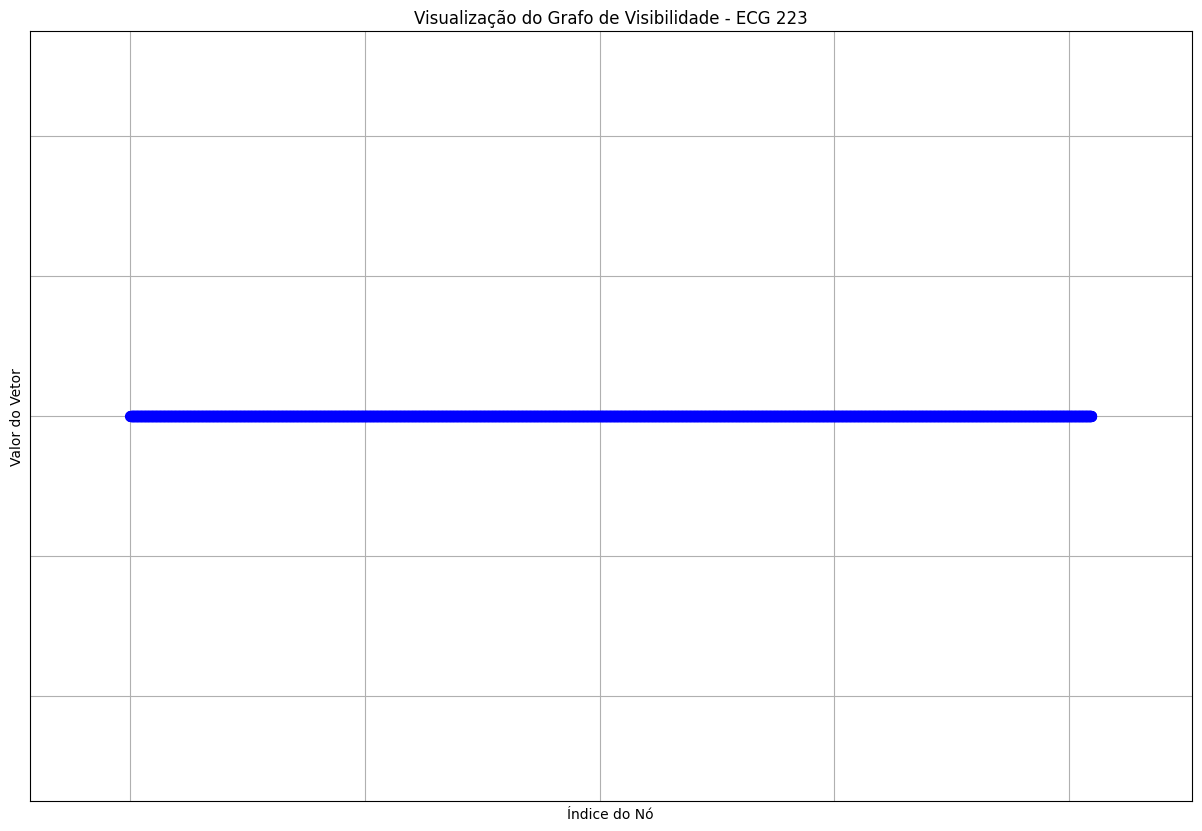

In [111]:
def visualizar_grafo_com_matplotlib(pt_path, indice):
    """
    Carrega os tensores salvos em um arquivo .pt e visualiza o grafo de um ECG especificado usando Matplotlib.

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        indice (int): Índice do ECG a ser visualizado.
    """
    # Carrega os dados salvos
    try:
        dados_salvos = torch.load(pt_path)
        grafos = dados_salvos['grafos']
        vetores = dados_salvos['vetores']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    # Verifica se o índice está dentro do intervalo válido
    if indice < 0 or indice >= len(grafos):
        print(f"Índice {indice} está fora do intervalo válido (0-{len(grafos)-1}).")
        return

    grafo = grafos[indice]
    vetor = vetores[indice]

    src = grafo['src'].cpu().numpy()
    dst = grafo['dst'].cpu().numpy()

    # Verifica se o vetor tem o mesmo número de nós que esperado
    num_nodes = len(vetor)
    max_node = max(np.max(src), np.max(dst))
    if max_node >= num_nodes:
        print("Atenção: O vetor fornecido não cobre todos os nós do grafo.")
        num_nodes = max_node + 1  # Atualiza o número de nós

    # Criar o grafo com NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(zip(src, dst))
    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Definir posições dos nós
    # Exemplo: x = índice do nó, y = valor do vetor
    pos = {i: (i, vetor[i]) for i in range(num_nodes)}

    # Plotar o grafo
    plt.figure(figsize=(15, 10))
    # Desenhar arestas
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    # Desenhar nós
    nodes = nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    # Opcional: adicionar rótulos aos nós
    # nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Visualização do Grafo de Visibilidade - ECG {indice}")
    plt.xlabel("Índice do Nó")
    plt.ylabel("Valor do Vetor")
    plt.grid(True)
    plt.show()

# Exemplo de uso:
if __name__ == "__main__":
    # Caminho para o arquivo .pt salvo anteriormente
    pt_path = 'grafos/umdavb.pt'

    # Índice do ECG a ser visualizado
    indice = 223  # Substitua pelo índice desejado

    # Chamar a função de visualização
    visualizar_grafo_com_matplotlib(pt_path, indice)